# 2A.data - Classification, régression, anomalies - corrigé - Gabriel ROMON

Le jeu de données [Wine Quality Data Set](https://archive.ics.uci.edu/ml/datasets/Wine+Quality) contient 5000 vins décrits par leurs caractéristiques chimiques et évalués par un expert. Peut-on s'approcher de l'expert à l'aide d'un modèle de machine learning ?

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Les données

Le fichier .csv est à [cette adresse](https://raw.githubusercontent.com/sdpython/ensae_teaching_cs/master/src/ensae_teaching_cs/data/data_2a/wines-quality.csv).

On peut le télécharger directement depuis le notebook (il sera stocké dans le dossier où se trouve le notebook).

In [2]:
import urllib.request

url = 'https://raw.githubusercontent.com/sdpython/ensae_teaching_cs/master/src/ensae_teaching_cs/data/data_2a/wines-quality.csv'
urllib.request.urlretrieve(url, './wines-quality.csv')

('./wines-quality.csv', <http.client.HTTPMessage at 0x291d17bfb00>)

On ouvre le fichier avec `pandas`:

In [3]:
df = pd.read_csv('./wines-quality.csv')  #crée un DataFrame contenant les données
df.head()  #affiche les 5 premières lignes du DataFrame

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


## Exercice 1 : afficher la distribution des notes


In [14]:
sorted(df['quality'].unique())

[3, 4, 5, 6, 7, 8, 9]

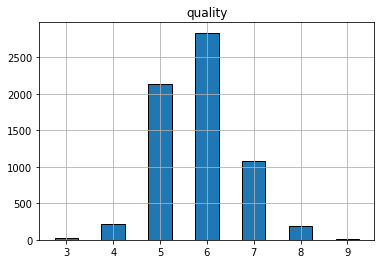

In [15]:
hist = df.hist(column='quality', bins=range(3,11), ec='black', align='left', rwidth=0.5)

J'explicite les paramètres `bins=range(3,11)` et `align='left'` pour des raisons purement esthétiques (essayez sans).

Si `bins=[x_0,...,x_n]`, l'histogramme crée les bins `[x_0,x_1[`,..., `[x_(n-2),x_(n-1)[`, `[x_(n-1),x_n]`. Comme dans le dernier bin la borne de droite est incluse, il faut spécifier `bins=range(3,11)` et pas `bins=range(3,10)`.

***

On observe que la distribution des notes est approximativement gaussienne. Elle n'est pas uniforme (pas équilibrée), on est donc dans un cas de *unbalanced classification*.

## Exercice 2 : séparation train / test


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('quality', axis=1), df['quality'],
                                                    test_size=0.33, random_state=42)

L'argument `test_size=0.33` signifie que le test set contient 33% des lignes du jeu de départ.

## Exercice 3 : la variable couleur n'est pas numérique

Il est plus simple et naturel de convertir la variable catégorielle en variable binaire avec `pandas` plutôt que d'utiliser le OneHotEncoder de `sklearn`.

In [22]:
df['color'].unique()

array(['red', 'white'], dtype=object)

In [23]:
X_train.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
color                    object
dtype: object

On remarque que la variable `color` a le type générique `object`. C'est parce que ses valeurs sont les chaînes de caractères `"red"` et `"white"`.

In [24]:
X_train['color'].astype('category')

1700    white
5199    white
3340    white
86        red
5587    white
        ...  
3772    white
5191    white
5226    white
5390    white
860       red
Name: color, Length: 4352, dtype: category
Categories (2, object): [red, white]

In [25]:
X_test['color'].astype('category')

3103    white
1419      red
4761    white
4690    white
4032    white
        ...  
3767    white
1068      red
1942    white
1647    white
2683    white
Name: color, Length: 2145, dtype: category
Categories (2, object): [red, white]

La méthode `.astype('category')` permet de passer du type `object` au type catégoriel `category` (binaire dans ce cas).  
`Categories (2, object): [red, white]` indique que `0` correspond à `red` et `1` correspond à `white`.  
On note que l'encoding est le même dans `X_train` et `X_test`.

In [26]:
X_train['color'] = X_train['color'].astype('category').cat.codes  #remplace la colonne 'color' par sa version binaire
X_test['color'] = X_test['color'].astype('category').cat.codes

In [27]:
X_train['color']  #on vérifie que 1 correspond bien à 'white'.

1700    1
5199    1
3340    1
86      0
5587    1
       ..
3772    1
5191    1
5226    1
5390    1
860     0
Name: color, Length: 4352, dtype: int8

## Exercice 4 : premier classifieur

### La régression logistique binaire

Etant donnée une variable aléatoire $Y$ à valeurs dans $\{0,1\}$ et un vecteur aléatoire $X$ à valeurs dans $\mathbb R^d$ on souhaite approcher la loi conditionnelle de $Y$ sachant $X=x$ où $x\in \mathbb R^d$. On suppose que le modèle est paramétrique: $$Y|X=x \sim \text{Bernoulli}(\sigma(\theta^T x))$$
où $\theta\in \mathbb R^d$ est le paramètre (qu'on cherche à estimer) et $\sigma:t\mapsto \frac{1}{1+e^{-t}}$ est appelée fonction sigmoide.

Le but est de calculer un $\theta$ qui colle bien aux données d'entrainement. Une fois qu'on l'a calculé et qu'on a un nouveau vecteur de données $x\in \mathbb R^d$ en entrée, on évalue simplement $\sigma(\theta^T x)$. C'est la probabilité renvoyée par le modèle que $Y=1$. Si c'est $>\frac 12$ on prévoit $1$, et sinon on prévoit $0$.

Considérons la vraisemblance conditionnelle du modèle. Soit $(X_1,Y_1),\ldots, (X_n,Y_n)$ iid suivant la loi de $(X,Y)$. La vraisemblance conditionnelle est la densité conditionnelle de $(Y_1,\ldots,Y_n)$ sachant $(X_1,\ldots,X_n)=(x^{(1)},\ldots, x^{(n)})$.  
De la même manière que la vraisemblance usuelle est un produit de densités, la vraisemblance conditionnelle s'écrit comme un produit de densités conditionnelles:
$$L(\theta; y^{(1)},\ldots, y^{(n)},x^{(1)},\ldots, x^{(n)} ) = \prod_{i=1}^n P(Y=y^{(i)}|X=x^{(i)}) = \prod_{i=1}^n \sigma(\theta^T x^{(i)}))^{y^{(i)}} [1-\sigma(\theta^T x^{(i)})]^{1-y^{(i)}}$$
La log-vraisemblance conditionnelle s'écrit $$\log L(\theta; y^{(1)},\ldots, y^{(n)},x^{(1)},\ldots, x^{(n)} ) = \sum_{i=1}^n y^{(i)} \log \sigma(\theta^T x^{(i)})) + (1-y^{(i)}) \log(1-\sigma(\theta^T x^{(i)})) $$

Le problème d'optimisation à résoudre est $$\text{argmax}_{\theta \in \mathbb R^d} \sum_{i=1}^n y^{(i)} \log \sigma(\theta^T x^{(i)})) + (1-y^{(i)}) \log(1-\sigma(\theta^T x^{(i)}))$$
et sous forme de minimisation d'une loss (perte): 
$$\text{argmin}_{\theta \in \mathbb R^d} -\left[\sum_{i=1}^n y^{(i)} \log \sigma(\theta^T x^{(i)})) + (1-y^{(i)}) \log(1-\sigma(\theta^T x^{(i)})) \right]$$

Ce problème est bien convexe en $\theta$. Contrairement à la régression linéaire, il n'admet pas de minimiseur explicite. Pour le résoudre il faut utiliser une méthode de descente gradient ou des méthodes du second ordre (Newton).

*Remarque*: On pourrait aussi définir directement la loss associée à un échantillon $(x^{(i)},y^{(i)})$ comme $$-[y^{(i)} \log \sigma(\theta^T x^{(i)})) + (1-y^{(i)}) \log(1-\sigma(\theta^T x^{(i)}))]$$ 
Cette loss est appelée *log-loss* ou *binary cross-entropy*.

***

Il est intéressant de regarder la frontière de décision de la régression logistique. Le classifieur prévoit $1$ pour l'échantillon $x\in \mathbb R^d$ si et seulement si $\sigma(\theta^T x)>\frac 12$, i.e $\theta^T x >0$. En d'autre termes, la frontière de décision est un hyperplan (affine en supposant que la dernière coordonnée de $x$ est $1$).  
**La régression logistique ne peut donc donner de bons résultats que si les données sont linéairement séparables !**

### La régression multiclasse

Il existe plusieurs approches pour passer de classifieurs binaires (2 catégories) à des classifieurs multiclasse ($\geq 3$ catégories). Disons qu'il y a $C$ classes.

La première approche s'appelle *one-versus-rest*. On entraine un classifieur $g_1$ qui différencie entre la classe $1$ et les $C-1$ autres (le problème devient binaire), puis un classifieur $g_2$ qui différencie entre la classe $2$ et $C-1$ les autres, etc. Au total, on entraine $C$ classifieurs binaires $g_1,\ldots,g_C$. Etant donné un vecteur $x\in \mathbb R^d$ en entrée, on évalue $g_1(x),\ldots,g_C(x)$ et on prend le classifieur qui renvoie le plus grand score.

La deuxième approche s'appelle *one-versus-one*. Pour tout $i<j$ on entraine un classifieur $g_{ij}$ qui différencie entre les classes $i$ et $j$ (le problème devient binaire). Au total, on entraine $\frac{C(C-1)}{2}$ classifieurs binaires. Etant donné un vecteur $x\in \mathbb R^d$ en entrée, on évalue tous les $g_{ij}(x)$ et on prend le classifieur qui gagne le plus de duel.   
Il faut noter que pour entrainer $g_{ij}$ on a besoin de beaucoup moins de lignes que pour entrainer un classifieur en *one-versus-rest*.

La deuxième approche est plus avantageuse si l'entrainement des classifieurs scale mal avec le nombre de lignes dans les données d'entrainement (c'est le cas des SVM).

Dans `scikit-learn`, la [régression logistique](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) admet un paramètre `multi_class` dont la valeur par défaut est `ovr` (one versus rest).

### La régression logistique multinomiale

C'est une généralisation de la régression logistique usuelle. Elle prend directement en charge le cas multiclasse. Je vais éviter de passer par un modèle statistique et par l'écriture du maximum de vraisemblance.

Disons qu'il y a $C$ classes. Le paramètre à apprendre est une matrice $\Theta\in \mathbb R^{C\times d}$ dont la $k$ème ligne $\theta^{(k)}\in \mathbb R^d$ correspond au paramètre de la classe $k$.

La loss (semblable au cas binaire) s'écrit $$J(\Theta) = -\sum_{i=1}^n \sum_{k=1}^C y_k^{(i)} \log\left[ \frac{\exp({x^{(i)}}^T\theta^{(k)})}{\sum_{j=1}^C \exp({x^{(i)}}^T\theta^{(j)})} \right]$$

On peut vérifier qu'elle a bien du sens. Soit $i$ fixé. Il existe un unique $k_0$ tel que $y_{k_0}^{(i)}=1$ (le reste des $y_{k}^{(i)}$ sont $0$). L'argument du $\log$ $$ \frac{\exp({x^{(i)}}^T\theta^{(k_0)})}{\sum_{j=1}^C \exp({x^{(i)}}^T\theta^{(j)})}$$ correspond à la probabilité (renvoyée par le modèle) que la classe associée à l'échantillon $i$ soit $k_0$.  
Si cette probabilité est proche de $1$ (le modèle a bon), alors $$-y_{k_0}^{(i)} \log\left[ \frac{\exp({x^{(i)}}^T\theta^{(k_0)})}{\sum_{j=1}^C \exp({x^{(i)}}^T\theta^{(j)})} \right]\approx 0$$

Si cette probabilité est proche de $0$ (le modèle se trompe!) alors 
$$-y_{k_0}^{(i)} \log\left[ \frac{\exp({x^{(i)}}^T\theta^{(k_0)})}{\sum_{j=1}^C \exp({x^{(i)}}^T\theta^{(j)})} \right]\approx \infty$$

*Remarque*: la fonction $S:\mathbb R^C \to \Delta^C$ définie par $$ (s_1,\ldots,s_C)\mapsto \left(\ldots,\frac{\exp(s_k)}{\sum_{j=1}^C \exp(s_j)},\ldots \right)$$ s'appelle *softmax*. Vous la verrez partout en deep learning (classification d'images).

La régression logistique multinomial est implémentée dans `scikit-learn` avec le paramètre `multi_class='multinomial'`.

### Que choisir ?

https://stats.stackexchange.com/questions/52104/multinomial-logistic-regression-vs-one-vs-rest-binary-logistic-regression
***

### Evaluer la performance d'un classifieur 

Il existe plusieurs métriques d'évaluation de la performance d'un classifieur.

Etant donnée une classe $c$, on définit 4 quantités:  
le nombre de vrais positifs $VP$ (le vrai label est $c$ et le modèle a prédit $c$)  
le nombre de faux positifs $FP$ (le vrai label est $\neq c$ et le modèle a prédit $c$)  
le nombre de vrais négatifs $VN$ (le vrai label est $\neq c$ et le modèle a prédit $\neq c$)  
le nombre de faux négatifs $FN$ (le vrai label est $c$ et le modèle a prédit $\neq c$)  

#### Accuracy
L'accuracy d'un classifieur est la proportion de prédictions correctes (toutes classes confondues)

#### Precision
Pour une classe $c$ donnée, la précision est donnée par $$\text{precision} = \frac{VP}{VP+FP}$$
En d'autres termes on ne regarde que là où le classifieur a renvoyé $c$, et on calcule la proportion de prédictions correctes (les vrais positifs divisé par le nombre total de positifs renvoyés par le classifieur).

#### Recall
Pour une classe $c$ donnée, le recall est donnée par $$\text{recall} = \frac{VP}{VP+FN}$$
En d'autres termes on ne regarde que les exemples dont le vrai label est $c$, et parmi ceux là on regarde combien ont été correctement trouvés par le classifieur.
***

L'accuracy n'est pas une métrique pertinente lorsque la répartition des classes n'est pas équilibrée (unbalanced classification). En effet, considérons le cas des images de radiologie. Supposons qu'une tumeur survient chez $1\%$ de la population. Considérons le classifieur trivial qui renvoie $0$ quel que soit la radio (i.e. le classifieur dit tout le temps qu'il n'y a pas de tumeur). Alors on s'attend à ce que ce classifieur ait une accuracy de $99\%$ !!

En revanche ce classifieur a une précision qui n'est pas définie (elle vaut $\frac 00$) et un recall qui vaut $0$. Quand la répartition des classes n'est pas équilibrée, precision et recall sont bien plus pertinents.

***
Suivant le problème considéré on peut désirer juste une grande précision ou juste un grand recall.  
*Exemple*: un classifieur qui dit $1$ si une vidéo est ok pour les -18 ans. On veut une grande précision, quitte à avoir un petit recall. En d'autres termes on ne veut surtout pas laisser passer de vidéos +18 (on est prêt à rejeter beaucoup de vidéos qui sont pourtant ok pour les -18)  (on veut très peu de faux positifs, quitte à avoir beaucoup de faux négatifs).

*Exemple*: un classifieur qui dit $1$ si une personne vole dans un magasin (caméra de surveillance). On veut un grand recall, quitte à avoir une petite précision. En d'autres termes on veut attraper tous les voleurs, quitte à ce que des clients honnêtes soient identifier à tort comme des voleurs (on veut très peu de faux négatifs quitte à avoir beaucoup de faux positifs).

*Exemple*: un classifieur qui dit $1$ si une tumeur est présente sur une radio. On veut un grand recall, quitte à avoir une petite précision. En d'autres termes on ne veut pas louper de tumeurs, quitte à ce que le radiologue ait beaucoup de faux positifs.

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

#Régression logistique one versus rest
clf_log = LogisticRegression(random_state=42).fit(X_train, y_train)
print(classification_report(y_test, clf_log.predict(X_test)))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        76
           5       0.53      0.62      0.57       672
           6       0.51      0.69      0.59       977
           7       0.48      0.06      0.11       352
           8       0.00      0.00      0.00        57
           9       0.00      0.00      0.00         1

    accuracy                           0.52      2145
   macro avg       0.22      0.20      0.18      2145
weighted avg       0.48      0.52      0.46      2145



C:\Users\gabsens\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\gabsens\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\gabsens\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Calculons à la main la precision et le recall de la classe 5 avec le classifieur précédent.

In [31]:
labels =  np.c_[y_test, clf_log.predict(X_test)]

VP = len([row for row in labels if list(row)==[5,5]])
FP = len([1 for (lab1,lab2) in labels if lab1!=5 and lab2==5])
VP/(VP+FP) 

0.5294117647058824

In [32]:
FN = len([1 for (lab1,lab2) in labels if lab1==5 and lab2!=5])
VP/(VP+FN)

0.6160714285714286

On retrouve les mêmes chiffres !

***
Comme les classes ne sont pas équilibrées, on peut faire du [*cost-sensitive learning*](https://link.springer.com/referenceworkentry/10.1007%2F978-0-387-30164-8_181). Dans scikit-learn, ça revient à mettre `class_weight='balanced'`.

In [30]:
#Régression logistique one versus rest, cost-sensitive learning
clf_log = LogisticRegression(class_weight='balanced', random_state=42).fit(X_train, y_train)
print(classification_report(y_test, clf_log.predict(X_test)))

              precision    recall  f1-score   support

           3       0.01      0.10      0.03        10
           4       0.17      0.26      0.21        76
           5       0.52      0.60      0.55       672
           6       0.55      0.37      0.45       977
           7       0.35      0.33      0.34       352
           8       0.17      0.19      0.18        57
           9       0.01      1.00      0.01         1

    accuracy                           0.43      2145
   macro avg       0.26      0.41      0.25      2145
weighted avg       0.48      0.43      0.45      2145



C:\Users\gabsens\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\gabsens\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


***
Entrainons un random forest.

In [37]:
from sklearn.ensemble import RandomForestClassifier

#Random forest
clf_for = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42).fit(X_train, y_train)
print(classification_report(y_test, clf_for.predict(X_test)))

              precision    recall  f1-score   support

           3       0.50      0.10      0.17        10
           4       0.82      0.12      0.21        76
           5       0.66      0.74      0.70       672
           6       0.66      0.74      0.69       977
           7       0.70      0.51      0.59       352
           8       0.90      0.33      0.49        57
           9       0.00      0.00      0.00         1

    accuracy                           0.66      2145
   macro avg       0.61      0.36      0.41      2145
weighted avg       0.68      0.66      0.65      2145



C:\Users\gabsens\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Exercice 5 : courbe ROC


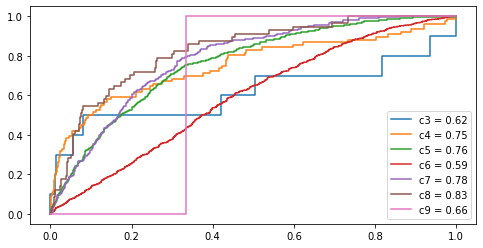

In [39]:
from sklearn.metrics import roc_curve, auc

labels = clf_log.classes_
y_score = clf_log.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i, cl in enumerate(labels):
    fpr[cl], tpr[cl], _ = roc_curve(y_test == cl, y_score[:, i])
    roc_auc[cl] = auc(fpr[cl], tpr[cl])
    
fig, ax = plt.subplots(1, 1, figsize=(8,4))
for k in roc_auc:
    ax.plot(fpr[k], tpr[k], label="c%d = %1.2f" % (k, roc_auc[k]))
ax.legend();

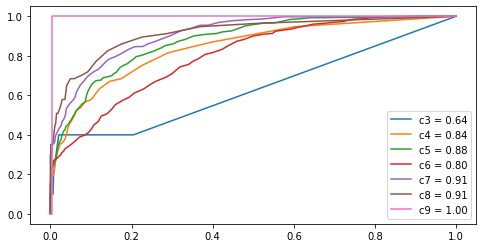

In [40]:
labels = clf_for.classes_
y_score = clf_for.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i, cl in enumerate(labels):
    fpr[cl], tpr[cl], _ = roc_curve(y_test == cl, y_score[:, i])
    roc_auc[cl] = auc(fpr[cl], tpr[cl])
    
fig, ax = plt.subplots(1, 1, figsize=(8,4))
for k in roc_auc:
    ax.plot(fpr[k], tpr[k], label="c%d = %1.2f" % (k, roc_auc[k]))
ax.legend();

## Exercice 6 : anomalies

Une anomalie est un point aberrant. Cela revient à dire que sa probabilité qu'un tel événement se reproduise est faible. Un modèle assez connu est [EllipticEnvelope](https://scikit-learn.org/stable/auto_examples/plot_anomaly_comparison.html). On suppose que si le modèle détecte une anomalie, un modèle de prédiction aura plus de mal à prédire. On réutilise le pipeline précédent en changeant juste la dernière étape.

In [7]:
from sklearn.covariance import EllipticEnvelope


## Exercice 7 : régression

La note est numérique, pourquoi ne pas essayer une régression.

In [8]:
from sklearn.ensemble import RandomForestRegressor

## Exercice 8 : intervalle de confiance
    
Comment constuire un intervalle de confiance avec un classifieur et un régresseur. Rien de théorique, juste des idées et un peu de bidouille.